In [1]:
from functools import partial
from itertools import product
import warnings
warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
from graspy.cluster import GaussianCluster
from graspy.embed import MultipleASE, OmnibusEmbed
from joblib import Parallel, delayed
from scipy.stats import ttest_ind

from src import generate_binary_sbms_with_communities

In [8]:
def estimate_embeddings(X, Y, method):
    """
    Parameters
    ----------
    method : str
        Must be {'mase', 'omni'}
    """
    stacked = np.vstack([X, Y])

    if method == "mase":
        embedder = MultipleASE(2)
        embeddings = embedder.fit_transform(stacked)
    elif method == "omni":
        embedder = OmnibusEmbed(2)
        embeddings = embedder.fit_transform(stacked).mean(axis=0)
    else:
        assert ValueError("Invalid embedding method")

    return embeddings


def estimate_community(embeddings, n_clusters):
    predicted_labels = (
        GaussianCluster(n_clusters, n_clusters, "all").fit_predict(embeddings) + 1
    )
    return predicted_labels


def compute_ttest(pop1, pop2):
    statistics, pvals = ttest_ind(pop1, pop2, axis=0)
    return pvals


def run_experiment(m, block_1, block_2, p, q, delta, n_clusters, reps):
    total_n = block_1 + block_2
    r, c = np.triu_indices(total_n, k=1)

    res = np.zeros((reps, 2))

    for i in np.arange(reps).astype(int):
        pop1, pop2, true_labels = generate_binary_sbms_with_communities(
            m=m, block_1=block_1, block_2=block_2, p=p, q=q, delta=delta
        )
        pop1_edges = pop1[:, r, c]
        pop2_edges = pop2[:, r, c]
        true_edges = (true_labels[:, None] + true_labels[None, :])[r, c]

        
        community_pvals = np.zeros(np.unique(true_edges).size)
        cluster_labels = np.unique(true_edges)
        for j in np.unique(true_edges):
            tmp_labels = true_edges == j

            statistics, pvals = ttest_ind(
                pop1_edges[:, tmp_labels].ravel(), pop2_edges[:, tmp_labels].ravel(),
            )
            community_pvals[j] = pvals
            
            
        #find the most significant group
        sig_edges = np.zeros((total_n, total_n))[r, c]

        sig_comm = cluster_labels[np.argsort(community_pvals, kind='stable')[0]]
        sig_edges[true_edges == sig_comm] = 1
                

        prec = (sig_edges[true_edges == 0]).sum() / sig_edges.sum()
        recall = (sig_edges[true_edges == 0]).sum() / (true_edges == 0).sum()

        res[i] = (prec, recall)

    res = np.nanmean(res, axis=0).reshape(-1)

    to_append = [m, p, q, delta, *res]
    return to_append

In [9]:
block_1 = 25  # different probability
block_2 = 25
n_clusters = range(2, 3)
p = 0.5
q = 0.5
reps = 100
spacing = 50
deltas = np.linspace(0, 1 - p, spacing + 1)
ms = np.linspace(0, 250, spacing + 1)[1:]

partial_func = partial(
    run_experiment,
    block_1=block_1,
    block_2=block_2,
    p=p,
    q=q,
    n_clusters=n_clusters,
    reps=reps,
)
args = [dict(m=m, delta=delta) for m, delta in product(ms, deltas)]
# args = sum(zip(reversed(args), args), ())[: len(args)]

In [10]:
res = Parallel(n_jobs=-1, verbose=7)(delayed(partial_func)(**arg) for arg in args)

cols = ["m", "p", "q", "delta", "prec", "recall"]
res_df = pd.DataFrame(res, columns=cols)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 392 tasks      | elapsed:   31.6s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 896 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1096 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 2056 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 2550 out of 2550 | elapsed: 13.5min finished


In [12]:
res_df.to_csv(f"../results/20200409_correct_edges_true_label.csv", index=False)

## Figures

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%matplotlib inline

In [5]:
res_df = pd.read_csv("../results/20200322_correct_nodes.csv")
res_df = res_df[res_df.delta != 0]
res_df.head()

,m,p,q,delta,prec,recall
1,5.0,0.5,0.5,0.01,0.590909,0.13
2,5.0,0.5,0.5,0.02,0.606178,0.19
3,5.0,0.5,0.5,0.03,0.768538,0.32
4,5.0,0.5,0.5,0.04,0.976562,0.63
5,5.0,0.5,0.5,0.05,0.887983,0.83


In [6]:
res_df.shape

(2500, 6)

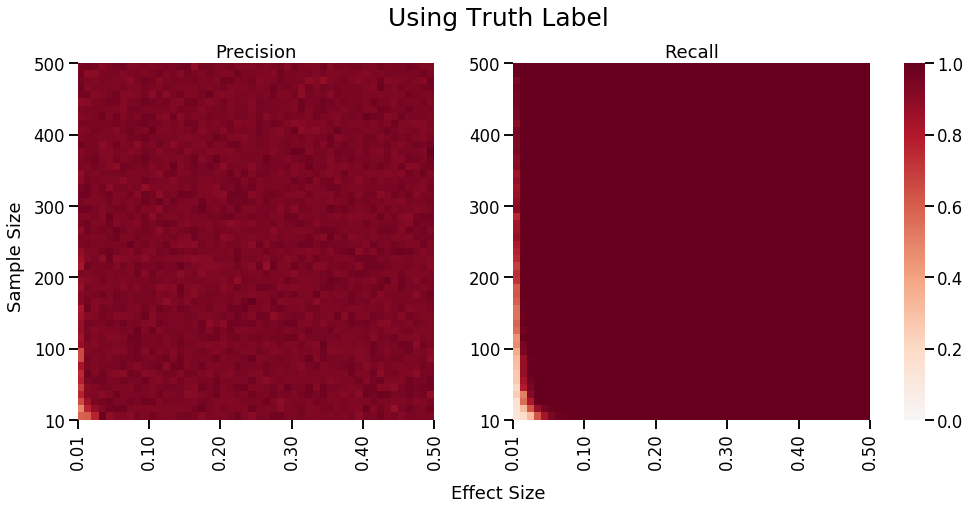

In [12]:
p = 0.5
spacing = 50

xticklabels = np.linspace(0, 1 - p, spacing + 1)[::10]
xticklabels[0] += 0.01
yticklabels = np.linspace(0, 250, spacing + 1)[::10] * 2
yticklabels[0] += 10

# Make figure with correct subplots
sns.set_context("talk", font_scale=1)
fig, ax = plt.subplots(
    1,
    3,
    gridspec_kw={"width_ratios": [1, 1, 0.05]},
    figsize=(13, 6),
    # sharex=True,
    # sharey=True,
    constrained_layout=True,
)

for i, metric in enumerate(["prec", "recall"]):
    sns.heatmap(
        np.flipud(res_df[metric].values.reshape(spacing, -1)),
        ax=ax[i],
        square=True,
        center=0,
        cmap="RdBu_r",
        cbar_kws=dict(shrink=0.7),
        xticklabels=["{:.2f}".format(x) for x in xticklabels],
        yticklabels=["{:.0f}".format(y) for y in yticklabels],
        cbar_ax=ax[-1],
        vmin=0,
        vmax=1,
    )
    ax[i].set_xticks(np.arange(0, ax[0].get_xlim()[1] + 1, 10))
    ax[i].set_yticks(np.arange(0, ax[0].get_ylim()[0] + 1, 10)[::-1])

ax[0].set_title("Precision")
ax[1].set_title("Recall")
fig.text(0.5, 1.05, f"Using Truth Label", fontsize=25, va="center", ha="center")
fig.text(-0.025, 0.5, "Sample Size", va="center", rotation="vertical")
fig.text(0.5, -0.05, "Effect Size", va="center", ha="center")

fig.savefig(f"./exp3_truth_label.png", dpi=300, bbox_inches="tight")
fig.savefig(f"./exp3_truth_label.pdf", dpi=300, bbox_inches="tight")